In [1]:
# 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# XOR 데이터  양수(1) 음수(0) 일경우에는 양수(1)고 나머지는 음수(0)
LABELS = [0,0,1,1] 
CENTERS = [(-3,-3),(3,3),(-3,3),(3,-3)]

In [11]:
class MultilayerPerceptron(nn.Module):
    """
    가중치 초기화 
    input_size : 입력 크기
    hidden_size : 은닉층 크기
    output_size : 출력 크기
    num_hidden_layers : 은닉층 개수
    hidden_activation : 활성화 함수
    """
    def __init__(self, input_size, hidden_size=2, output_size=3, num_hidden_layers=1, hidden_activation=nn.Sigmoid):
        super(MultilayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()
        interim_input_size =  input_size
        interim_output_size = hidden_size
        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size,interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size
        self.fc_final = nn.Linear(interim_input_size,  output_size)  
        self.last_forward_cache = []
    # MLP 정방향 계산
    def forward(self, x, apply_softmax = False):  # 크로스 엔트로피를 사용하려면 apply_softmax 가 false
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to('cpu').numpy())
        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to('cpu').numpy())
        output = self.fc_final(x)
        self.last_forward_cache.append(x.to('cpu').numpy())
        if apply_softmax:
            output = F.softmax(output, dim=1)
        return output

In [4]:
# 데이터 생성함수
def get_data(batch_size):
    x_data = []
    y_target = np.zeros(batch_size)
    n_center = len(CENTERS)
    for batch_i in range(batch_size):
        center_idx = np.random.randint(0,n_center)
        x_data.append(np.random.normal(loc = CENTERS[center_idx]))
        y_target[batch_i] = LABELS[center_idx]
    return torch.tensor(x_data,dtype=torch.float32), torch.tensor(y_target, dtype=torch.int16)

In [26]:
# 결과 시각화 함수
def visulize_results(perceptron, x_data,y_truth,n_samples=1000, ax=None, epoch=None,
                     title='',levels=[0.3,0.4,0.5], linestyles=['--','-','--']):
    _, y_pred =  perceptron(x_data,apply_softmax=True).max(dim=1)
    y_pred = y_pred.data.numpy()
    
    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy()
    
    n_classess = len(set(LABELS))
    
    all_x =[ []  for _ in range(n_classess)]
    all_colors =[ []  for _ in range(n_classess)]
    
    colors = ['orange','green']
    markers = ['o', '*']
    enge_color = {'o':'orange', '*':'green'}
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append('white')
        else:
            all_colors[y_true_i].append(colors[y_true_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))    

    for x_list, color_list,marker in zip(all_x, all_color,markers):
        ax.scatter(x_list[:,0],x_list[:,1], edgecolor=enge_color[marker], marker=marker, facecolor=color_list,s=100)
    xlim = (
        min( [ x_list[:,0].min() for x_list in all_x  ]  ),
        max( [ x_list[:,0].max() for x_list in all_x  ]  )
    )
    ylim = (
        min( [ x_list[:,1].min() for x_list in all_x  ]  ),
        max( [ x_list[:,1].max() for x_list in all_x  ]  )
    )
    # 평면    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(xlim[0], xlim[1], 30)
    YY, XX = np.meshgrid(yy,xx)
    xy = np.vstack([XX.ravel(), YY.ravel()] ).T
    
    for i in range(n_classess):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32), apply_softmax =True)
        Z = Z[:,i].data.numpy().reshape(XX.shape)
        ax.contour(XX,YY, Z, colors=colors[i], levels=levels, linestyles = linestyles)
    # 부가적인 출력
    plt.title(title)    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], f'Epoch = {epoch}')
    

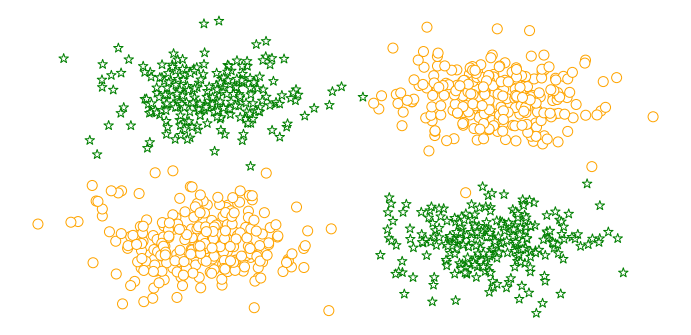

In [7]:
# 초기데이터 그래프
import numpy as np
import matplotlib.pylab as plt
seed = 24
torch.manual_seed(seed)
np.random.seed(seed)

x_data, y_truth =  get_data(batch_size=1000)
x_data =  x_data.data.numpy()
y_truth = y_truth.data.numpy().astype(np.int64)
n_classes = len(set(LABELS))

all_x = [ [] for _ in range(n_classes) ]
all_color = [ [] for _ in range(n_classes) ]

colors = ['orange','green']
markers = ['o','*']

for x_i, y_truth_i in zip(x_data, y_truth):
    all_x[y_truth_i].append(x_i)
    all_color[y_truth_i].append(colors[y_truth_i])

all_x = [np.stack(x_list) for x_list in all_x]    

_, ax = plt.subplots(1,1,figsize=(10,5))
for x_list, color, marker in zip(all_x, all_color,markers):
    ax.scatter(x_list[:,0],x_list[:,1], edgecolor = color, marker=marker, facecolor='white',s=100)
plt.tight_layout()
plt.axis('off')
plt.title('');
plt.savefig('inital_data.png', dpi=300)

MultilayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


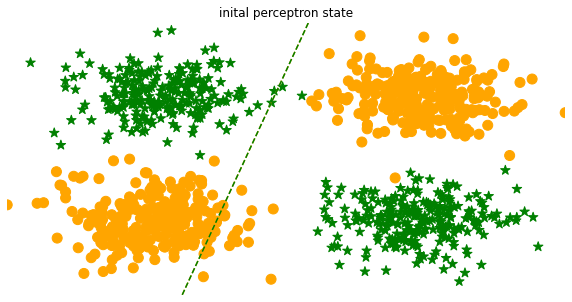

In [27]:
# 퍼셉트론 훈련
input_size = 2
output_size = len(set(LABELS ))
num_hidden_layers = 0
hidden_size = 2 # 사용하지 않지만 지정만..
seed = 24
torch.manual_seed(seed)
np.random.seed(seed)

mlp1 = MultilayerPerceptron(input_size = input_size
                            , hidden_size = hidden_size
                            , num_hidden_layers=num_hidden_layers
                            ,output_size=output_size
                            )
print(mlp1)
batch_size = 1000

x_data_static, y_truth_static =  get_data(batch_size)
fig, ax = plt.subplots(1,1, figsize = (10,5))

visulize_results(mlp1,x_data_static, y_truth_static, ax=ax, title='inital perceptron state', levels=[0.5])
plt.axis('off')
plt.savefig('perceptron_initial.png',dpi=300)

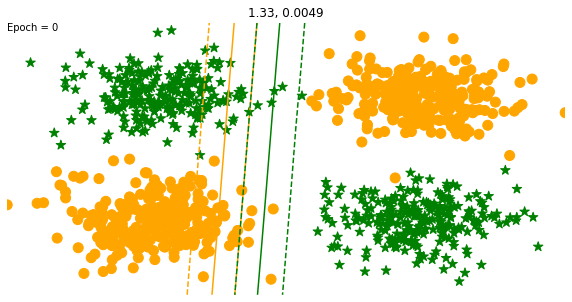

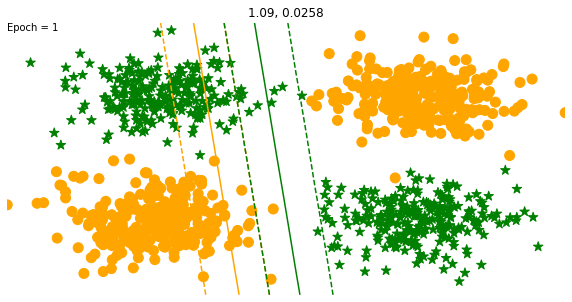

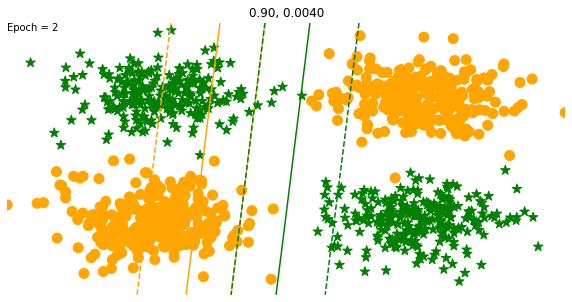

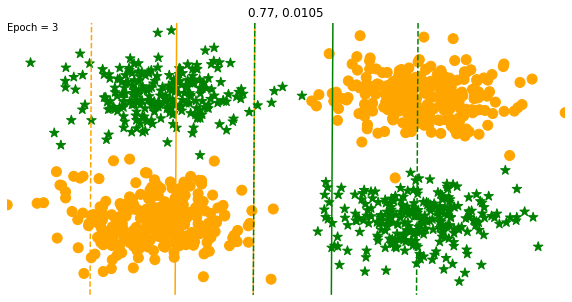

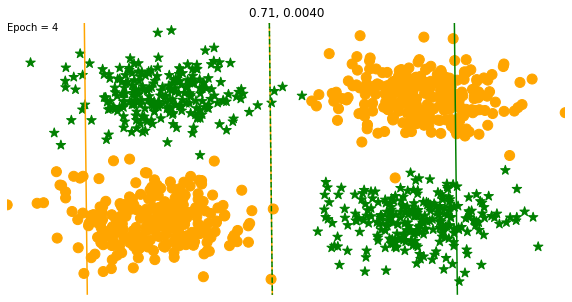

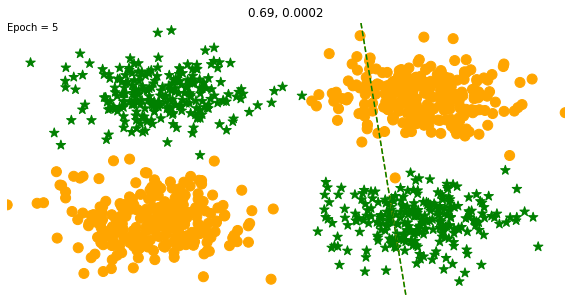

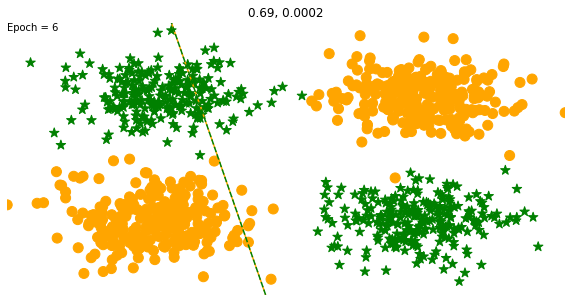

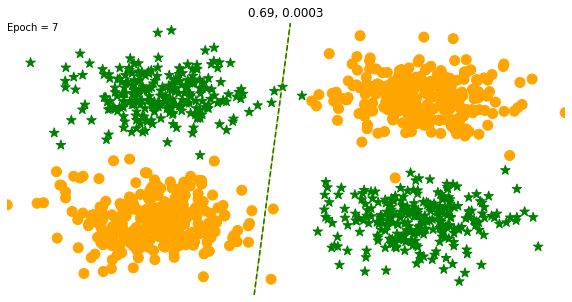

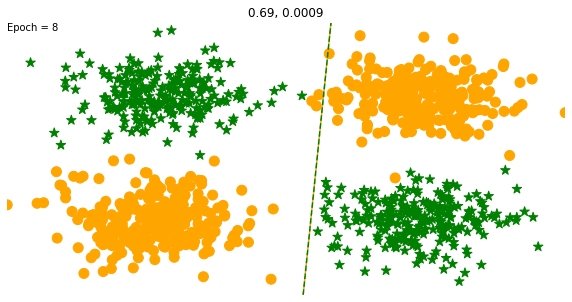

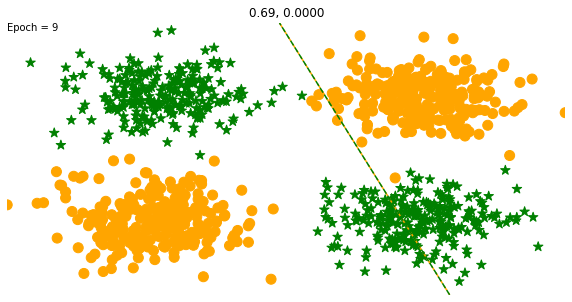

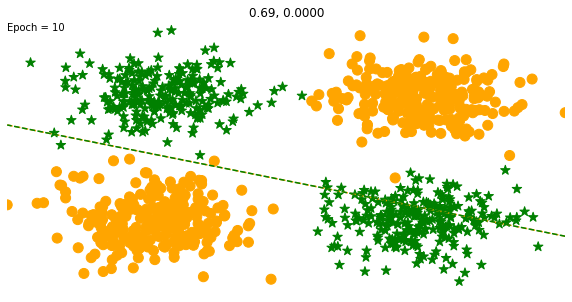

In [28]:
# 단층 퍼셉트론 훈련
losses = []
batch_size = 10000
n_batchs = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-3
epoch=0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp1.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change,change_threshold,epoch, max_epochs):
  terminate_for_loss_change = loss_change < change_threshold
  terminate_for_epochs = epoch > max_epochs
  return terminate_for_epochs

while not early_termination(loss_change,change_threshold,epoch,max_epochs):
  for _ in range(n_batchs):
    # 데이터 추출
    x_data,y_target =  get_data(batch_size)
    #  그레이디언트 초기화
    mlp1.zero_grad()
    # 정방향 계산
    y_pred =  mlp1(x_data).squeeze()
    # 손실(오차)계산
    loss = cross_ent_loss(y_pred, y_target.long())
    # 역전파(역방향 계산)
    loss.backward()
    # 옵티마이져 단계  수행
    optimizer.step()
    #각종 부가정보
    loss_value = loss.item()
    losses.append(loss_value)
    loss_change = abs(last_loss - loss_value)
    last_loss = loss_value

  fig, ax = plt.subplots(1,1,figsize=(10,5))    
  visulize_results(mlp1,x_data_static,y_truth_static,ax=ax, epoch=epoch,title=f"{loss_value:.2f}, {loss_change:.4f}")
  plt.axis('off')
  epoch+=1
  all_imagefiles.append(f'perceptron_epoch{epoch}_learning.png')
  plt.savefig(all_imagefiles[-1],dpi=300)